In [2]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [3]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


## 멀티에이전트 협업 네트워크

멀티 에이전트를 LangGraph를 활용하여 구현하는 방법입니다.  
멀티 에이전트 네트워크는 복잡한 작업을 여러 개의 전문화된 에이전트들로 나누어 처리하는 `분할 정복` 접근 방식을 사용하는 아키텍처 입니다.  
  
멀티 에이전트의 특징은 다음과 같습니다:  

- 도구 사용 로직이 복잡하지 않습니다. 
- 에이전트가 한 번에 처리해야 할 정보 양이 감소합니다.  

`분할 정복` 접근을 사용하면 각 에이전트는 특정 업무나 전문성 영역에 집중할 수 있고, 전체 작업이 네트워크 형태로 나뉘어 처리됩니다.  
각 에이전트는 자신이 잘하는 일을 처리하고, 필요 시 해당 업무를 다른 전문 에이전트에게 위임하거나 도구를 적절히 활용합니다.  
  
##### 참고자료

- [LangGraph 멀티 에이전트 네트워크 개념](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network)
- [AutoGen 논문: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)

##### 그래프 흐름

![multi_agent](./assets/langgraph_use_case_multi_agent.png)

### 기능 구현

#### 모델 정의

In [4]:
from models import get_model_name, LLMs

# 모델명 정의
MODEL_NAME = get_model_name(LLMs.GPT4o_MINI)
print(MODEL_NAME)

gpt-4o-mini


#### 웹 검색 도구 정의

In [7]:
# 웹 검색 도구 초기화
from tools_tavily import TavilySearch

# 최대 검색 결과를 3으로 설정
tavily_tool = TavilySearch(max_results=5)

#### 코드 실행 도구 정의

In [6]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


# Python 코드를 실행하는 도구 정의
python_repl = PythonREPL()


# Python 코드를 실행하는 도구 정의
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # 주어진 코드를 Python REPL에서 실행하고 결과 반환
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"
    # 실행 성공 시 결과와 함께 성공 메시지 반환
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### 에이전트 생성

#### Research Agent

`TavilySearch` 도구를 사용하여 연구를 수행하는 에이전트를 생성합니다. 이 에이전트는 필요한 정보를 리서치하는데 사용합니다.

In [8]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [9]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME)

# Research Agent 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


# Research Agent 노드 정의
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # Research Agent 의 메시지 목록 반환
        "messages": [last_message],
    }

#### Char Generator Agent

`PythonREPL` 도구를 사용하여 차트를 생성하는 에이전트를 생성합니다.

In [10]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""

# Chart Generator Agent 생성
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(chart_generator_system_prompt),
)

### 그래프 정의 

#### 1. 노드 정의

In [15]:
from langgraph.graph import END


# Research Agent 노드 정의
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # Research Agent 의 메시지 목록 반환
        "messages": [last_message],
    }


# 차트 노드
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        # share internal message history of chart agent with other agents
        "messages": [last_message],
    }


# 라우터
def router(state: MessagesState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

#### 2. 엣지 설정 및 그래프 컴파일

In [16]:
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())

#### 3. 그래프 시각화

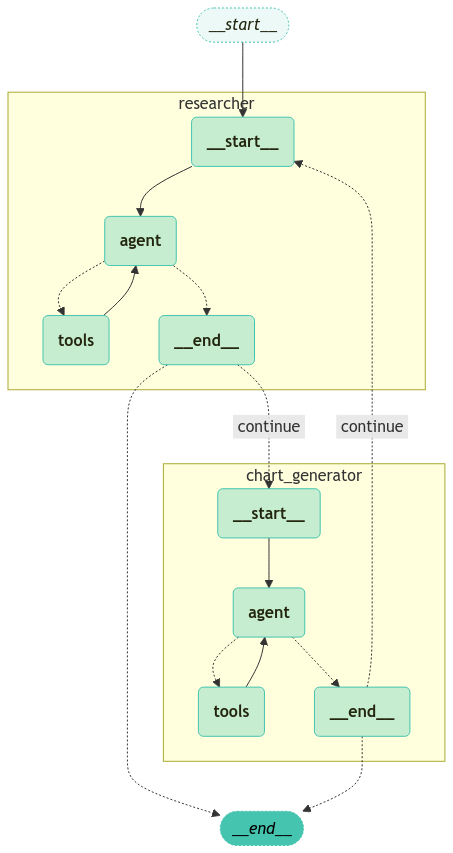

In [17]:
from graphs import visualize_graph

visualize_graph(app, xray=True)

#### 4. 실행


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_kTxqOtVmaRhGTEYAnJrqzvDb)
 Call ID: call_kTxqOtVmaRhGTEYAnJrqzvDb
  Args:
    query: Bitcoin price forecast January to December 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Based on the gathered data, here are the projected Bitcoin prices for each month in 2024:

| Month      | Minimum Price ($) | Average Price ($) | Maximum Price ($) |
|------------|--------------------|--------------------|--------------------|
| January    | 43,033.18          | 45,251.73          | 48,725.16          |
| February   | 46,003.98          | 47,771.53          | 49,730.16          |
| March      | 47,246.09          | 49,061.36          | 51,072.88          |
| April      | 48,52

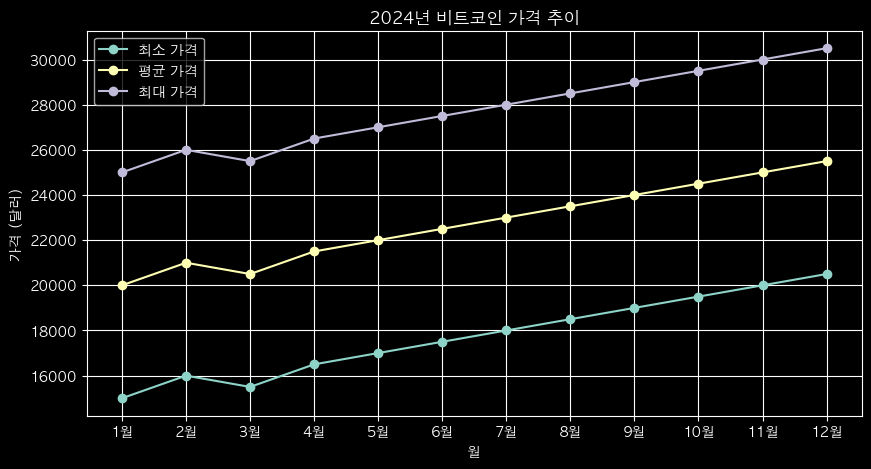


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

FINAL ANSWER

I have generated the graph visualizing the projected Bitcoin prices for 2024, showing the minimum, average, and maximum prices from January to December. The chart is titled "2024년 비트코인 가격 추이". If you need further assistance or modifications, let me know!

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

FINAL ANSWER

I have generated the graph visualizing the projected Bitcoin prices for 2024, showing the minimum, average, and maximum prices from January to December. The chart is titled "2024년 비트코인 가격 추이". If you need further assistance or modifications, let me know!


In [21]:

from langchain_core.runnables import RunnableConfig
from langchain_print import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2024년 1월부터 12월까지 비트코인 가격 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])